In [1]:
from IPython.core.display import HTML
style = """
<style>
.container {width: 90% !important;}
div.prompt {min-width: 12ex;}
div.output_area {overflow-y: scroll;}
div.output_area img {max-width: unset;}
div.output_subarea {max-width: unset;}
</style>
"""
HTML(style)

In [2]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import os

### Разведочный анализ

In [3]:
data_dir = '../../Final_work_data'
df = pd.read_csv(os.path.join(data_dir, 'ml_data.csv'), dtype=str)
df['target'] = df['target'].astype(int)
df.head()

,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city,target
0,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,wvtWRwiRmvPIsSQuXnvd,mobile,Android,Huawei,NaN,360x780,Chrome,Russia,Saint Petersburg,0
1,ZpYIoDJMcFzVoPFsHGJL,banner,zxoiLxhuSIFrCeTLQVWZ,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Xiaomi,NaN,393x851,Chrome,Russia,Chelyabinsk,0
2,BHcvLfOaCWvWTykYqHVe,cpc,NaN,NaN,JajANoFxoqXfKRNBUhzx,desktop,Windows,NaN,NaN,2560x1080,Chrome,Russia,Moscow,0
3,BHcvLfOaCWvWTykYqHVe,cpc,NaN,NaN,zXjuoqEaPElBnwpSHMpx,mobile,Android,Samsung,NaN,412x915,Chrome,Russia,Podolsk,0
4,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,desktop,Windows,NaN,NaN,1536x864,Chrome,Estonia,Tallinn,0


Приведем к нижнему регистру те предикторы, которые представляют собой слова или фразы:

In [4]:
cols_to_lower = ['device_category', 'device_os', 'device_brand', 'device_browser', 
                 'geo_country', 'geo_city']
df.loc[:, cols_to_lower] = df.loc[:, cols_to_lower].apply(lambda x: x.str.lower())

Поищем, какие символы уже могли быть использованы в датасете для пустых значений.

In [5]:
[s for s in pd.unique(df.drop(columns=['target']).dropna().values.ravel())
 if any(xs in s for xs in ['non', 'nul', 'not'])]

['(not set)', '(none)']

In [6]:
s1 = df.isna().sum()
s2 = (df == '(none)').sum()
s3 = (df == '(not set)').sum()
pd.concat([s1, s2, s3], keys=['NaN', '(none)', '(not set)'], axis=1)

,NaN,(none),(not set)
utm_source,76,0,0
utm_medium,0,277060,405
utm_campaign,195287,0,0
utm_adcontent,304137,0,0
utm_keyword,1020752,0,0
device_category,0,0,0
device_os,1013964,0,309
device_brand,347196,0,16392
device_model,1717204,0,0
device_screen_resolution,0,0,0


Думаю, можно заполнить все эти значения единообразно значением (none).

In [7]:
df.fillna('(none)', inplace=True)
df.replace('(not set)', '(none)', inplace=True)
(df == '(none)').sum() / len(df)

utm_source                  0.000044
utm_medium                  0.160175
utm_campaign                0.112735
utm_adcontent               0.175572
utm_keyword                 0.589258
device_category             0.000000
device_os                   0.585518
device_brand                0.209892
device_model                0.991305
device_screen_resolution    0.000000
device_browser              0.000006
geo_country                 0.000618
geo_city                    0.042313
target                      0.000000
dtype: float64

In [8]:
print(len(df))
print('')

vc_target = df['target'].value_counts(normalize=True)
print(vc_target)

1732266

0    0.970955
1    0.029045
Name: target, dtype: float64


Датасет сильно несбалансирован по целевому признаку.

Посмотрим на то, с какой частотой различные значения признаков встречаются в 
* датасете
* отфильтрованном датасете, где target = 1

In [9]:
from matplotlib.colors import ListedColormap
cmap = ListedColormap(['#3c78d8', '#8ec400'])

mpl.rcParams['legend.edgecolor'] = '#2fd7b4'

for k, v in mpl.rcParams.items():
    if v == 'black':
        mpl.rcParams[k] = '#28324a'
        

def plot_categorical_stats(feats, max_cats = 15):
    
    df_by_target = df.groupby('target')
    
    for feat in feats:
        fig = plt.figure(figsize=(8, 0.4 * max_cats))
        ax = plt.gca()
        vc = df_by_target[feat].value_counts().unstack(fill_value=0).transpose()
        vc['all'] = vc[0] + vc[1]
        vc = vc[['all', 1]]
        vc *= 100 / len(df)
        vc[1] /= vc_target[1]
        vc_plot = vc.sort_values(by=['all'], ascending=False).iloc[0:max_cats]
        vc_plot.plot(ax=ax, kind='barh', colormap=cmap).legend(title='target', loc='lower right')
        ax.set_xlabel('%')
        ax.set_ylabel('')
        ax.invert_yaxis()
        ax.set_title('{} - {} categories'.format(feat, len(vc)))
        fig.savefig('../presentation/{}.png'.format(feat), bbox_inches='tight')
        
    plt.show()

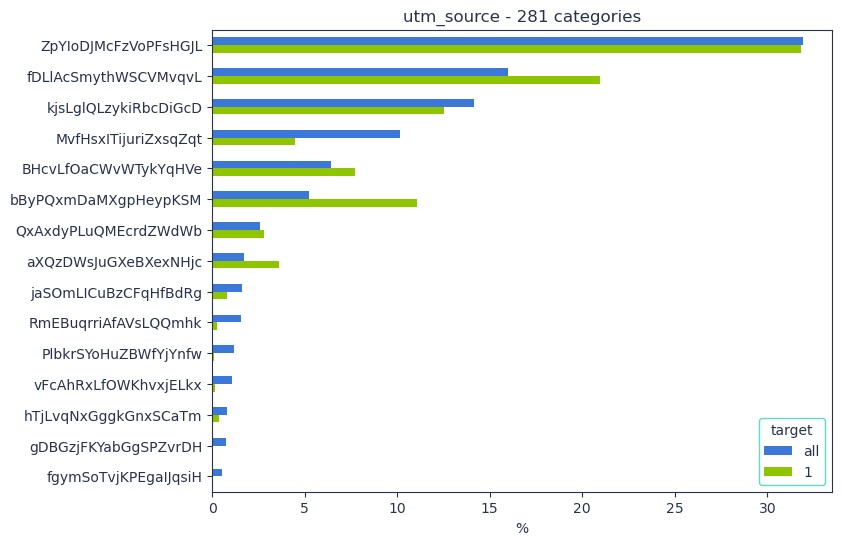

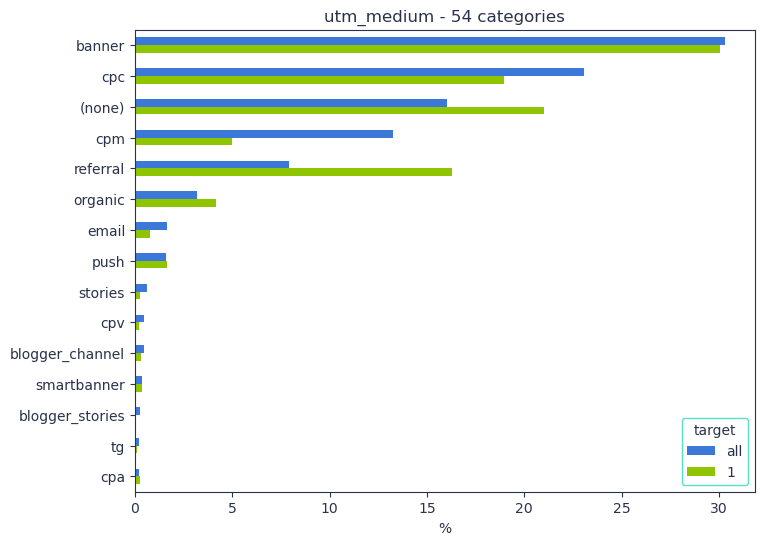

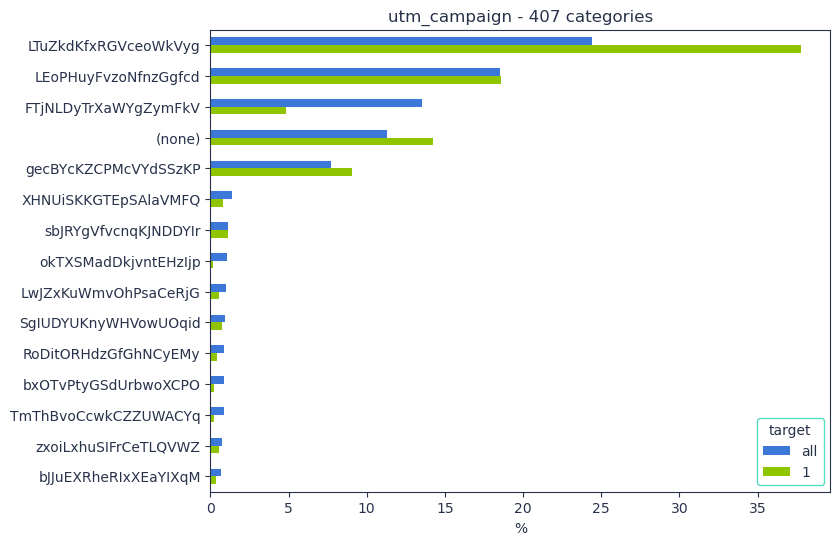

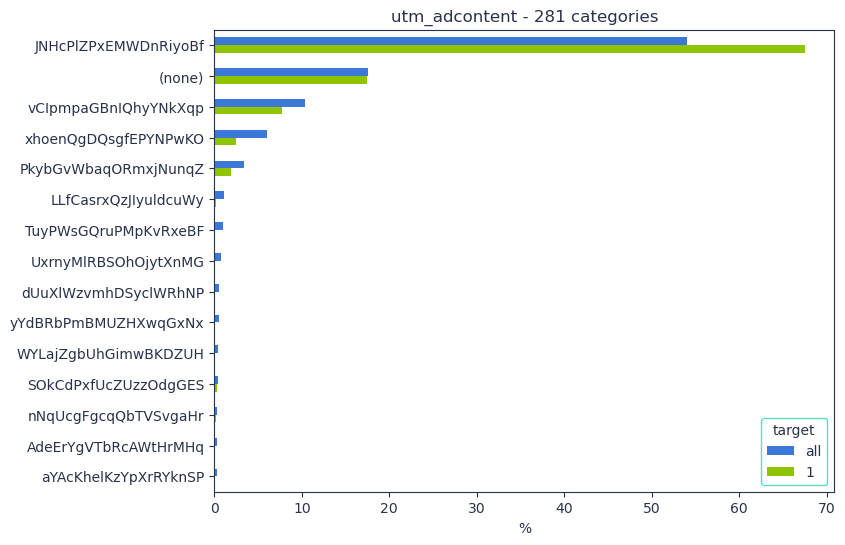

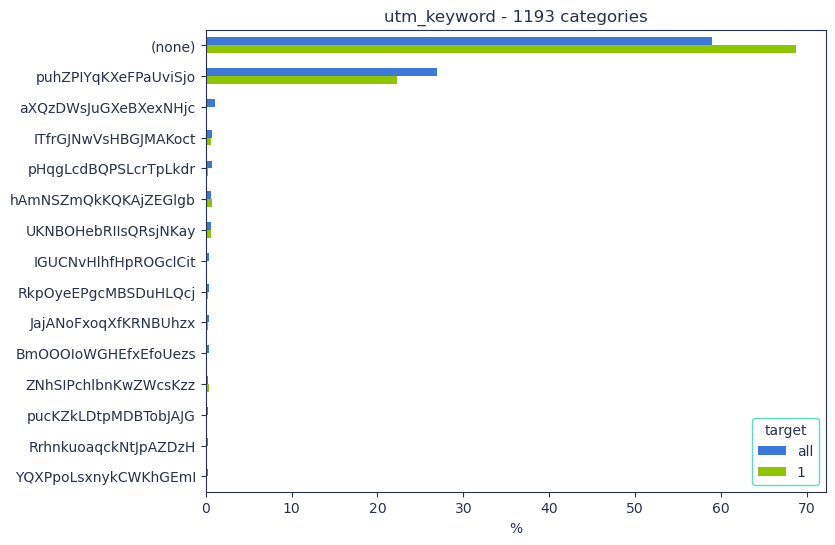

In [10]:
cols_utm = [x for x in df.columns if x.startswith('utm')]
plot_categorical_stats(cols_utm)

Признаки, начинающиеся с utm, являются аналитическими метками, которые добавляются в URL. Насколько я понимаю, метка может отсутствовать, поэтому (none) заполнять не надо.

In [11]:
(df[[x for x in df.columns if x.startswith('device')]] == '(none)').sum() / len(df)

device_category             0.000000
device_os                   0.585518
device_brand                0.209892
device_model                0.991305
device_screen_resolution    0.000000
device_browser              0.000006
dtype: float64

Удалим признак device_model c 99% пропусков, а также записи с пропусками в поле device_browser, которых крайне мало.

In [12]:
df.drop(columns=['device_model'], inplace=True)
df = df[df['device_browser'] != '(none)']

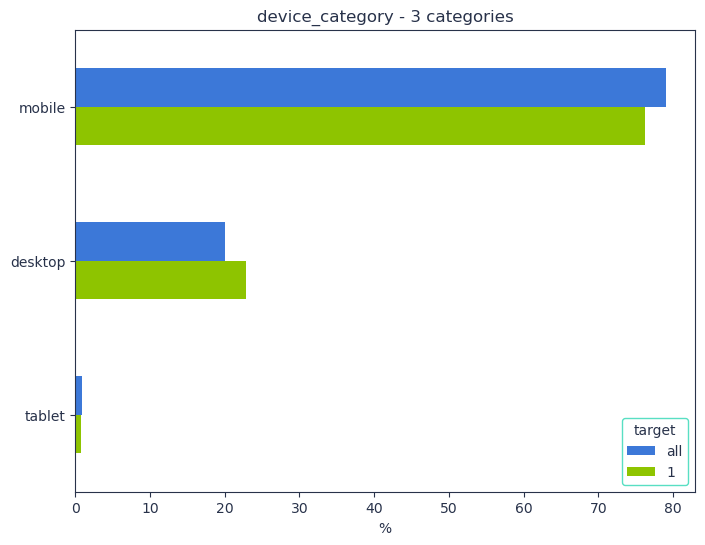

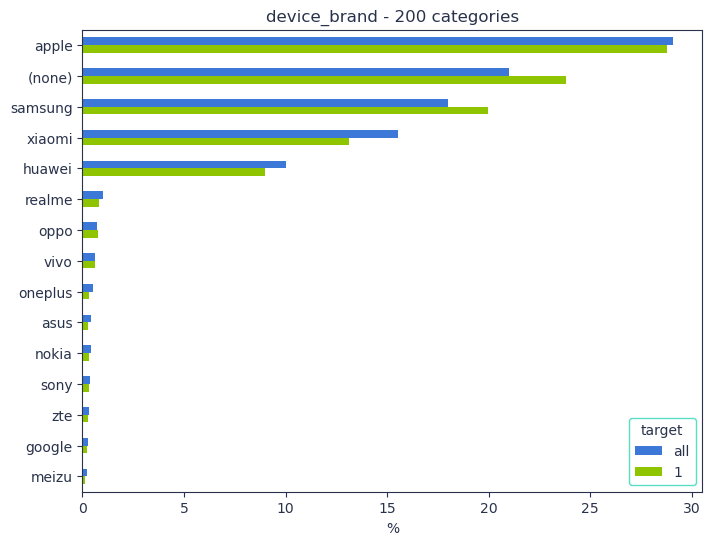

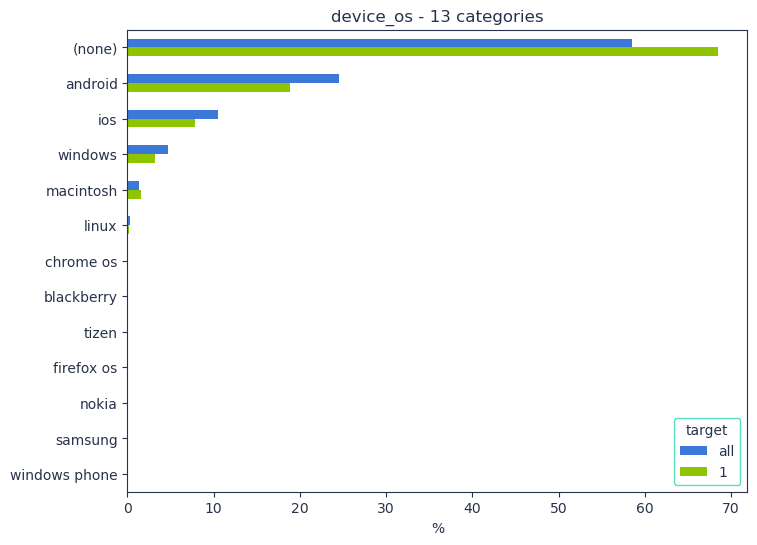

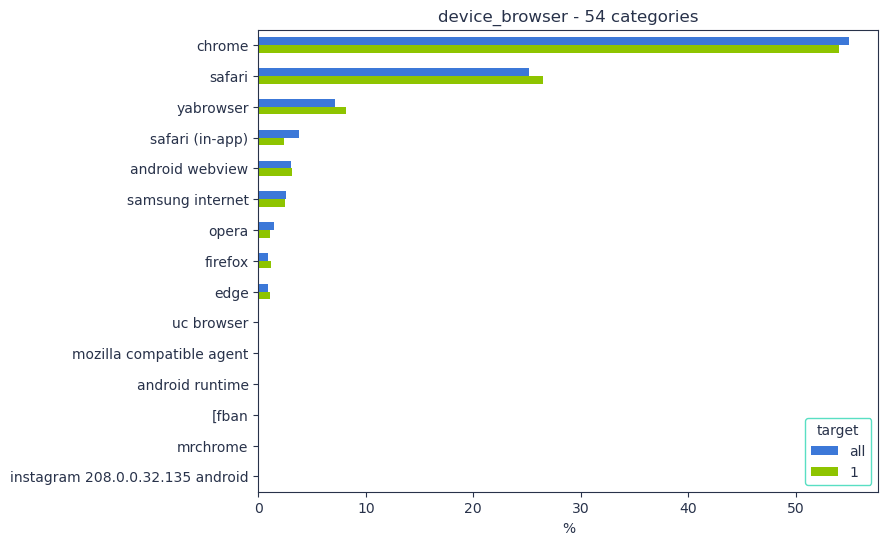

In [13]:
plot_categorical_stats(['device_category', 'device_brand', 'device_os', 'device_browser'])

In [14]:
df['device_browser'].value_counts()

chrome                              951573
safari                              436705
yabrowser                           123765
safari (in-app)                      65952
android webview                      51919
samsung internet                     44273
opera                                25094
firefox                              15738
edge                                 15196
uc browser                             815
mozilla compatible agent               336
android runtime                        241
[fban                                  115
mrchrome                                72
instagram 208.0.0.32.135 android        72
instagram 209.0.0.21.119 android        49
android browser                         47
puffin                                  43
maxthon                                 30
internet explorer                       24
opera mini                              23
android                                 19
instagram 202.0.0.23.119                17
mozilla    

In [15]:
def browser_filter(s):
     return ''.join([c for c in s if c.isalpha()])

df.loc[:, 'device_browser'] = df.loc[:, 'device_browser'].apply(browser_filter)

Заполним пропуски в device - признаках. Предполагаю, что OS Macintosh должна стоять на десктопах от Apple, а iOS на мобильных устройствах.

In [16]:
print('device_os = macintosh')
print(df[df['device_os'] == 'macintosh'][['device_category', 'device_brand']].value_counts())
print('')
print('device_os = ios')
print(df[df['device_os'] == 'ios'][['device_category', 'device_brand']].value_counts())

device_os = macintosh
device_category  device_brand
desktop          (none)          23395
mobile           (none)             10
tablet           (none)             10
dtype: int64

device_os = ios
device_category  device_brand
mobile           apple           180902
tablet           apple             1659
desktop          apple               31
mobile           (none)               5
dtype: int64


Для устройств с ОС Macintosh производитель не указан, но я верю, что это Apple. Также есть случаи, когда iOS стоит на десктопах, а Macintosh на мобильных устройствах, но этих случаев мало. Скорее всего, это ошибки.

Заполним такие пропуски до разбиения на train/test, т.к. способ заполнения очевиден и не поменяется при любом разбиении.

In [17]:
def fillna(cond, field, value):
    df.loc[cond & (df[field] == '(none)'), field] = value
    
fillna((df['device_os'] == 'macintosh') | (df['device_os'] == 'ios'), 'device_brand', 'apple')
fillna((df['device_brand'] == 'apple') & (df['device_category'] == 'desktop'), 'device_os', 'macintosh')
fillna(df['device_brand'] == 'apple', 'device_os', 'ios')

(df[['device_os', 'device_brand']] == '(none)').sum() / len(df)

device_os       0.400242
device_brand    0.196367
dtype: float64

В поле device_os остается 40% пропусков, и детерминированно заполнить его больше нельзя. Поэтому удалим это поле.

In [18]:
df.drop(columns=['device_os'], inplace=True)

C Apple мы разобрались, посмотрим на устройства других прозводителей. Начнем с декстопов.

In [19]:
cond = (df['device_brand'] != 'apple') & (df['device_category'] == 'desktop')
df[cond][['device_brand']].value_counts()

device_brand
(none)          323356
huawei              19
xiaomi              10
samsung              8
realme               5
google               4
flexymove            3
oppo                 3
beelink              2
oneplus              2
asus                 1
nokia                1
philips              1
dtype: int64

Думаю, что для не-Apple десктопов можно не заполнять (none) в поле device_brand, т.к. такие компьютеры собраны из компонентов различных производителей и у них нет "бренда". Те значения device_brand, кроме (none), которые все же присутствуют в списке - это производители мобильных устройств. Вероятно, они попали сюда по ошибке (или ошибка в поле device_category).

Посмотрим на мобильные устройства всех производителей, кроме Apple.

In [20]:
cond = (df['device_brand'] != 'apple') & (df['device_category'] != 'desktop')
df[cond][['device_brand']].value_counts()

device_brand
samsung         311633
xiaomi          269241
huawei          173809
realme           17921
(none)           16801
                 ...  
t-mobile             1
tagital              1
tanix                1
dragon touch         1
maxvi                1
Length: 198, dtype: int64

Заполним пропуски после разделения на train/test.

In [21]:
df['device_screen_resolution'].value_counts()

414x896      155140
1920x1080    119213
393x851      107972
375x812      106961
360x780       86718
              ...  
2376x1350         1
1848x1139         1
3840x2657         1
424x847           1
498x1107          1
Name: device_screen_resolution, Length: 4947, dtype: int64

Распарсим строковый признак device_screen_resolution и создадим численные признаки device_screen_width и device_screen_height. Также логично создать признаки

device_screen_area, равный площади экрана<br>
device_screen_aspect, равный отношению ширины и высоты экрана

In [22]:
df[['device_screen_width', 'device_screen_height']] = df['device_screen_resolution'].str.split('x', expand=True).astype(int)
df = df[(df['device_screen_width'] > 0) & (df['device_screen_height'] > 0)]

df['device_screen_area'] = df['device_screen_width'] * df['device_screen_height']
df['device_screen_aspect'] = df['device_screen_width'] / df['device_screen_height']

cols_num = ['device_screen_width', 'device_screen_height', 'device_screen_area', 'device_screen_aspect']

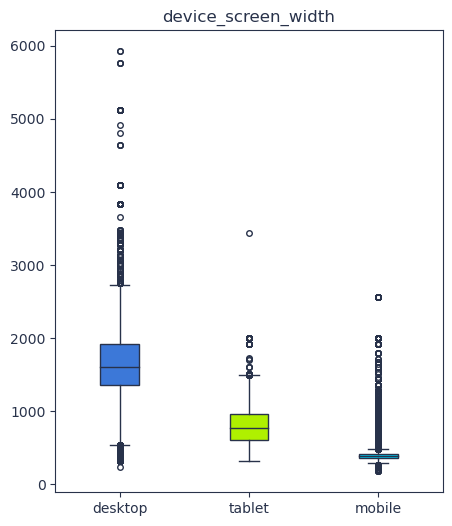

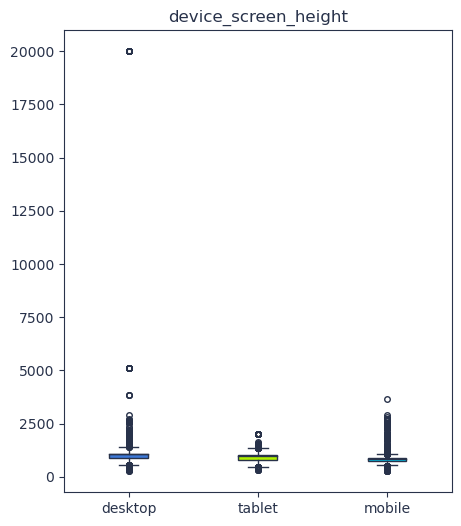

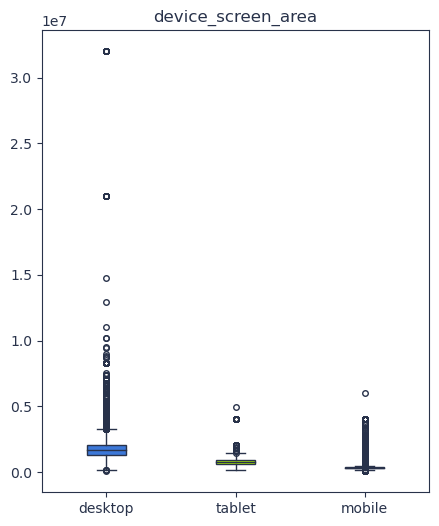

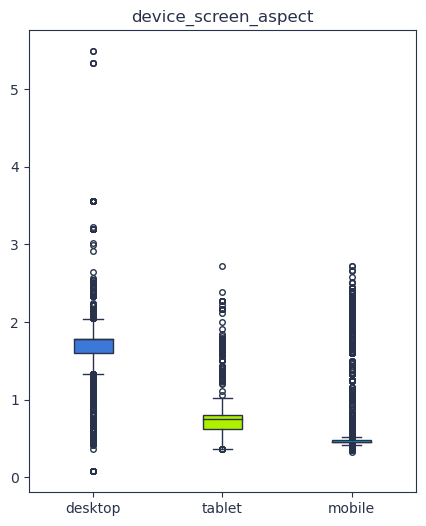

In [23]:
mpl.rcParams['boxplot.flierprops.markersize'] = 4.0
mpl.rcParams['boxplot.medianprops.color'] = '#28324a'

plot_num = 0

def show_boxplots(feats=cols_num):
    
    global plot_num
    plot_num += 1
    
    df_by_category = df.groupby('device_category')
    order = ['desktop', 'tablet', 'mobile']
    colors = ['#3c78d8', '#aff000', '#00cef6']

    for feat in feats:
        d = df_by_category[feat].apply(list)[order]
        fig = plt.figure(figsize=(5, 6))
        ax=plt.gca()
        bp = ax.boxplot(d, patch_artist=True)
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
        ax.set_xticklabels(d.index)
        ax.set_title(feat)
        plt.show()
        fig.savefig('../presentation/{}_{}.png'.format(feat, plot_num))
        
show_boxplots()

Замечаем, что медианное значение признака device_screen_aspect больше 1 у десктопов и меньше 1 у мобильных устройств. Это логично, т.к. мониторы десктопов обычно располагаются "горизонтально", а телефоны обычно держат "вертикально". Но тогда непонятно, почему медианное значение device_screen_aspect у планшетов меньше 1, т.к. планшеты обычно держат "горизонтально".

Попробуем взять за ширину наибольшее значение из признаков device_screen_width и device_screen_height, а за высоту - наименьшее. Физические разрешения мониторов обычно обозначаются именно так (включая разрешения мобильных телефонов).

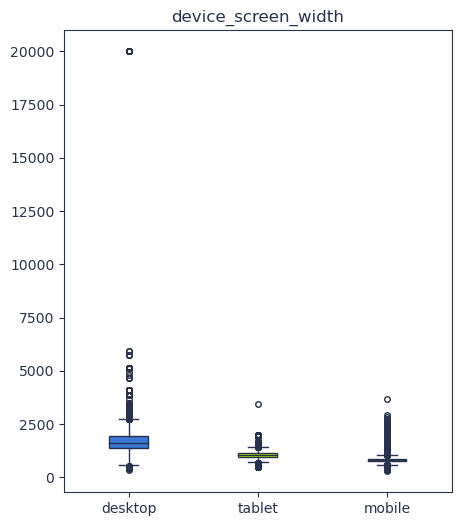

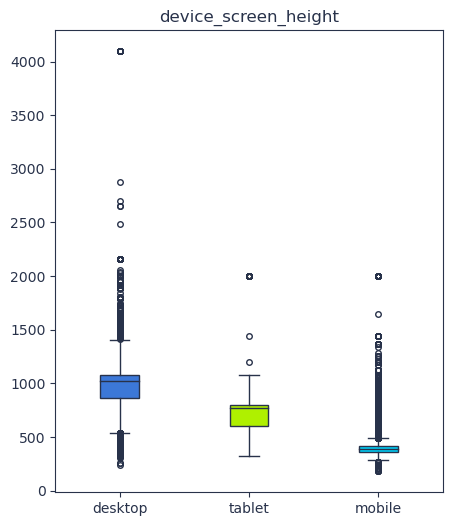

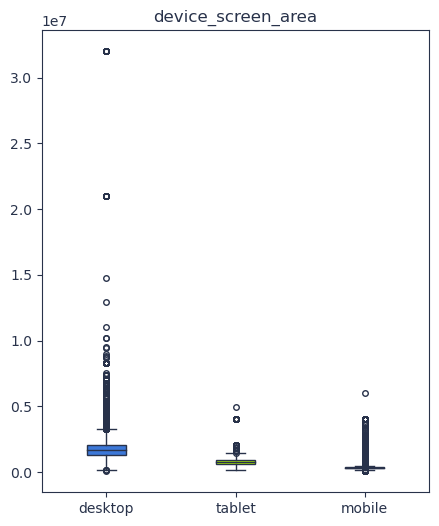

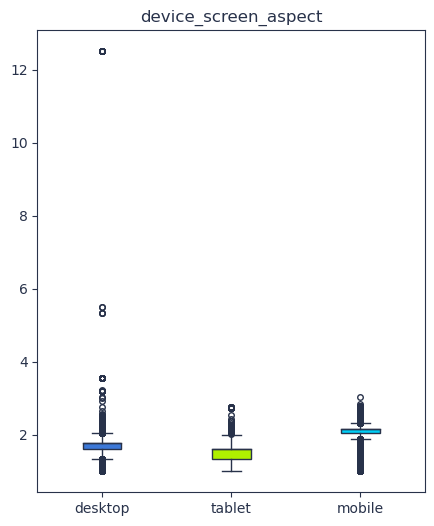

In [24]:
df_screen_size = df[['device_screen_width', 'device_screen_height']]
df['device_screen_width'], df['device_screen_height'] = df_screen_size.max(axis=1), df_screen_size.min(axis=1)

df['device_screen_area'] = df['device_screen_width'] * df['device_screen_height']
df['device_screen_aspect'] = df['device_screen_width'] / df['device_screen_height']

show_boxplots()

Точка с шириной 20000 - это явный выброс:

In [25]:
outliers = df['device_screen_width'] > 19000
df[outliers]

,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,target,device_screen_width,device_screen_height,device_screen_area,device_screen_aspect
282175,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,desktop,(none),1600x20000,chrome,(none),(none),0,20000,1600,32000000,12.5
301393,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,desktop,(none),1600x20000,chrome,(none),(none),0,20000,1600,32000000,12.5
313794,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,desktop,(none),1600x20000,chrome,(none),(none),0,20000,1600,32000000,12.5
439354,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,desktop,(none),1600x20000,chrome,(none),(none),0,20000,1600,32000000,12.5
479753,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,desktop,(none),1600x20000,chrome,(none),(none),0,20000,1600,32000000,12.5
488648,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,desktop,(none),1600x20000,chrome,(none),(none),0,20000,1600,32000000,12.5
536302,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,desktop,(none),1600x20000,chrome,(none),(none),0,20000,1600,32000000,12.5
536303,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,desktop,(none),1600x20000,chrome,(none),(none),0,20000,1600,32000000,12.5
659591,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,(none),desktop,(none),1600x20000,chrome,(none),(none),0,20000,1600,32000000,12.5
1024410,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,(none),desktop,(none),1600x20000,chrome,(none),(none),0,20000,1600,32000000,12.5


Очень трудно представить себе монитор с таким разрешением. Удалим выброс.

In [26]:
df = df[~outliers]

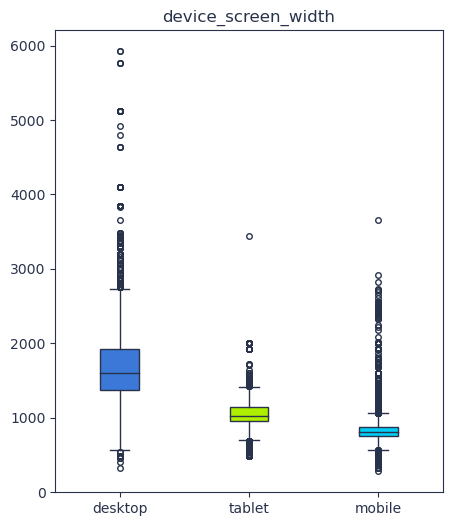

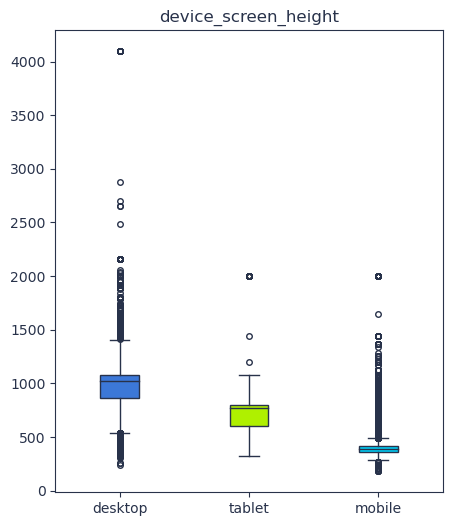

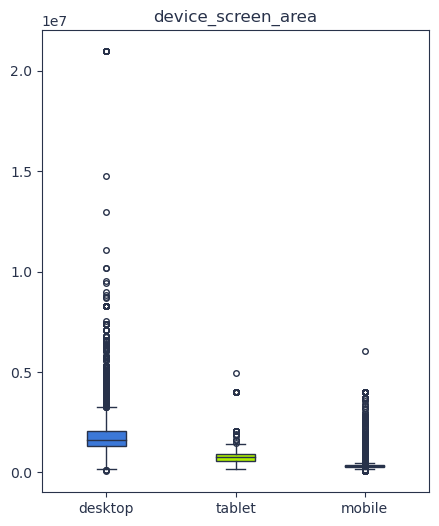

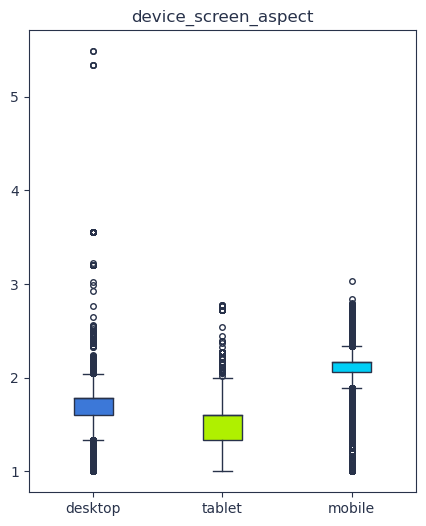

In [27]:
show_boxplots()

In [28]:
outliers = df['device_screen_width'] > 5500
df[outliers]

,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,target,device_screen_width,device_screen_height,device_screen_area,device_screen_aspect
909773,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,(none),desktop,(none),5760x1080,chrome,russia,samara,0,5760,1080,6220800,5.333333
1061252,PlbkrSYoHuZBWfYjYnfw,cpm,FTjNLDyTrXaWYgZymFkV,TuyPWsGQruPMpKvRxeBF,(none),desktop,(none),5924x1080,opera,russia,(none),0,5924,1080,6397920,5.485185
1139491,PlbkrSYoHuZBWfYjYnfw,cpm,FTjNLDyTrXaWYgZymFkV,TuyPWsGQruPMpKvRxeBF,(none),desktop,(none),5924x1080,opera,russia,(none),0,5924,1080,6397920,5.485185
1249533,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,(none),desktop,(none),5760x1080,chrome,russia,samara,0,5760,1080,6220800,5.333333
1400271,bByPQxmDaMXgpHeypKSM,referral,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,(none),desktop,(none),5760x1080,chrome,russia,samara,0,5760,1080,6220800,5.333333


5760x1080 - это, вероятно, три монитора 1920x1080

Кроме того, существуют одиночные мониторы с похожим разрешением и aspect ratio:
DWQHD 5120x1440

In [29]:
outliers = df['device_screen_height'] > 4000
df[outliers]

,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,target,device_screen_width,device_screen_height,device_screen_area,device_screen_aspect
154817,kjsLglQLzykiRbcDiGcD,cpc,UKNBOHebRIIsQRsjNKay,KdXimVMeVmlTGDTiqdWD,tzIeQUUHahhBuEkJqDVp,desktop,(none),4096x5120,chrome,russia,moscow,0,5120,4096,20971520,1.25
206448,fgymSoTvjKPEgaIJqsiH,cpm,FTjNLDyTrXaWYgZymFkV,yYdBRbPmBMUZHXwqGxNx,oKjXDUsycmahkgMhGdAR,desktop,(none),4096x5120,chrome,russia,moscow,0,5120,4096,20971520,1.25
1130067,geDcueAOghDzHkGMmdOq,cpm,FTjNLDyTrXaWYgZymFkV,WYLajZgbUhGimwBKDZUH,(none),desktop,(none),4096x5120,chrome,russia,mytishchi,0,5120,4096,20971520,1.25
1178416,RmEBuqrriAfAVsLQQmhk,cpc,iYBYglGljMDRQyqHRiPH,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,desktop,(none),4096x5120,chrome,russia,mytishchi,0,5120,4096,20971520,1.25
1264510,kjsLglQLzykiRbcDiGcD,cpc,agnCWMgbwJZgTVVsuCLg,vilbbyUvEWbiJvxXpaNN,(none),desktop,(none),4096x5120,chrome,russia,mytishchi,0,5120,4096,20971520,1.25
1291638,RmEBuqrriAfAVsLQQmhk,cpc,aLJBnHfwxXTnAjVTpHFh,JNHcPlZPxEMWDnRiyoBf,(none),desktop,(none),4096x5120,chrome,russia,mytishchi,0,5120,4096,20971520,1.25
1292079,RmEBuqrriAfAVsLQQmhk,cpc,aLJBnHfwxXTnAjVTpHFh,JNHcPlZPxEMWDnRiyoBf,(none),desktop,(none),4096x5120,chrome,russia,mytishchi,0,5120,4096,20971520,1.25
1351226,RmEBuqrriAfAVsLQQmhk,cpc,bgTYkDHjOsJzMUtoGhiQ,JNHcPlZPxEMWDnRiyoBf,(none),desktop,(none),4096x5120,chrome,russia,mytishchi,0,5120,4096,20971520,1.25
1360047,RmEBuqrriAfAVsLQQmhk,cpc,bgTYkDHjOsJzMUtoGhiQ,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,desktop,(none),4096x5120,chrome,russia,mytishchi,0,5120,4096,20971520,1.25
1441337,RmEBuqrriAfAVsLQQmhk,cpc,iYBYglGljMDRQyqHRiPH,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,desktop,(none),4096x5120,chrome,russia,mytishchi,0,5120,4096,20971520,1.25


Разрешение 5120х4096 существует (HSXGA).

In [30]:
outliers = (df['device_category'] == 'tablet') & (df['device_screen_width'] > 3000)
df[outliers]

,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,target,device_screen_width,device_screen_height,device_screen_area,device_screen_aspect
1057641,geDcueAOghDzHkGMmdOq,cpm,FTjNLDyTrXaWYgZymFkV,WYLajZgbUhGimwBKDZUH,(none),tablet,samsung,3440x1440,yabrowser,russia,saint petersburg,0,3440,1440,4953600,2.388889


Конкретно такое устройство не существует. Планшеты Samsung имеют максимальное разрешение 2960x1848 (Galaxy Tab S8 Ultra). Но существует, например, Wacom Cintiq Pro 16 с разрешением 3840x2160.

Все точки, которые boxplot отмечает, как выбросы, правдоподобны.

In [31]:
def show_scatterplots(feat0, feat1, lims0, lims1, title, legend_loc='best'):
    cat_colors = {'desktop': '#3c78d8', 'tablet': '#aff000', 'mobile': '#00cef6'}
    tgt_colors = {0: '#7f7f7f', 1: '#8ec400'}

    fig = plt.figure(figsize=(8, 6))

    for category in ['mobile', 'desktop', 'tablet']:
        df_cat = df[df['device_category'] == category]
        plt.scatter(df_cat[feat0], df_cat[feat1], c=cat_colors[category],
                    s=12, alpha=0.8, label=category)

    if lims0 != None: plt.xlim(lims0)
    if lims1 != None: plt.ylim(lims1)
    
    plt.xlabel(feat0)
    plt.ylabel(feat1)
    
    handles, labels = plt.gca().get_legend_handles_labels()
    order = [1, 2, 0]
    plt.legend(handles=[handles[i] for i in order], labels=[labels[i] for i in order], loc=legend_loc)
    
    title_plot = '{} by category'.format(title)
    plt.title(title_plot)    
    plt.show()
    fig.savefig('../presentation/{}.png'.format(title_plot))
    
    
    fig = plt.figure(figsize=(8, 6))
    
    for target in [0, 1]:
        df_tgt = df[df['target'] == target]
        plt.scatter(df_tgt[feat0], df_tgt[feat1], c=tgt_colors[target],
                    s=12, label=target)

    if lims0 != None: plt.xlim(lims0)
    if lims1 != None: plt.ylim(lims1)
    
    plt.xlabel(feat0)
    plt.ylabel(feat1)
    
    plt.legend(loc=legend_loc)
    
    title_plot = '{} by target'.format(title)
    plt.title(title_plot)    
    plt.show()
    fig.savefig('../presentation/{}.png'.format(title_plot))

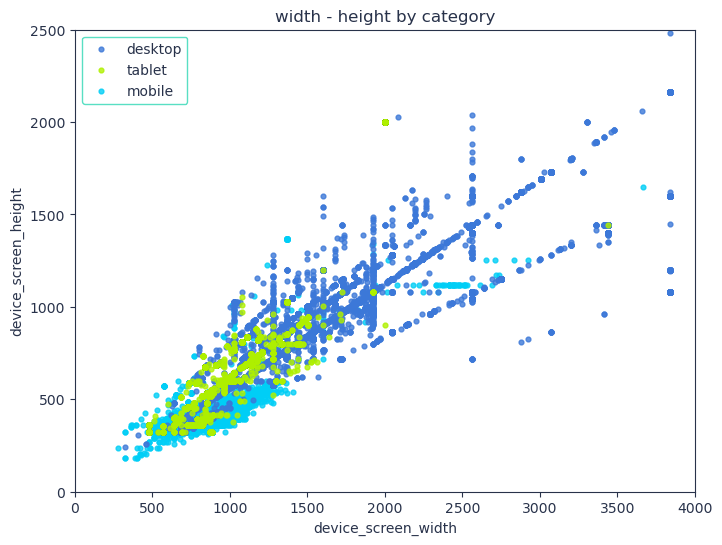

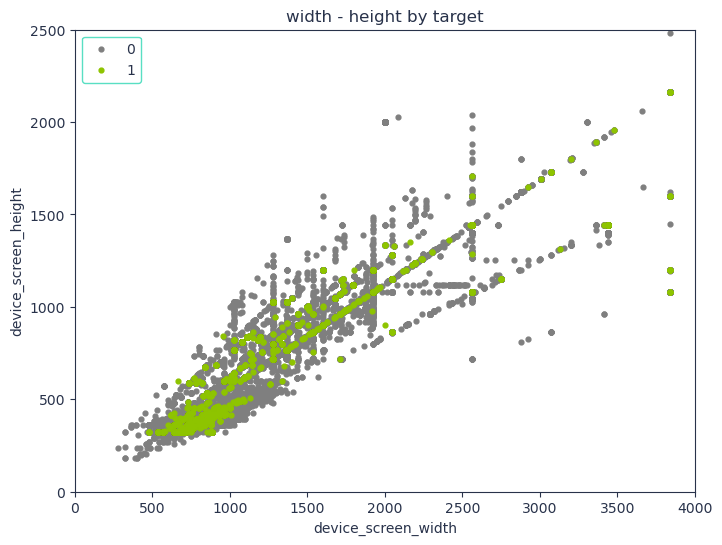

In [32]:
show_scatterplots('device_screen_width', 'device_screen_height', [0, 4000], [0, 2500], 'width - height', 'upper left')

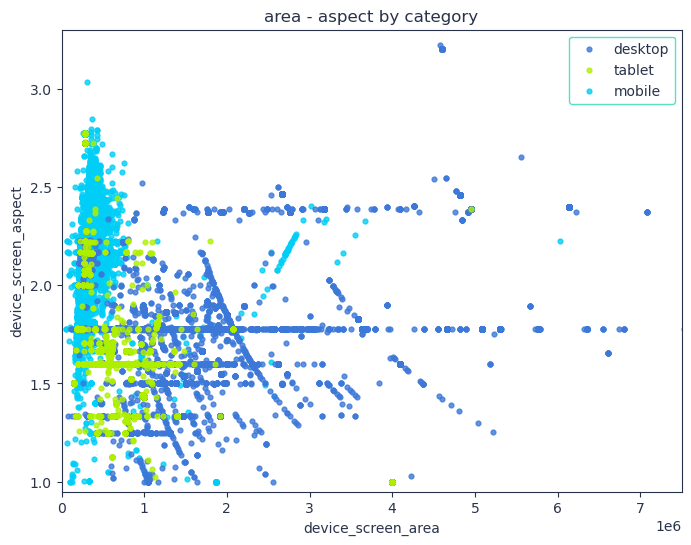

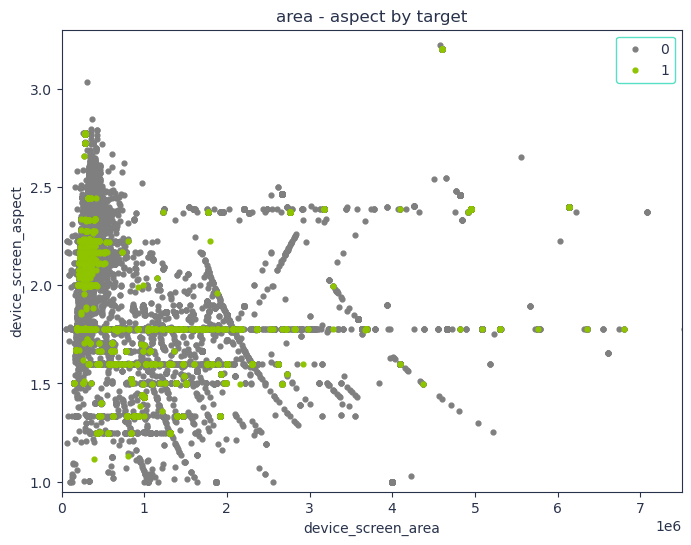

In [33]:
show_scatterplots('device_screen_area', 'device_screen_aspect', [-0.5, 7.5e+6], [0.95, 3.3], 'area - aspect')

In [34]:
df[cols_num].corr()

,device_screen_width,device_screen_height,device_screen_area,device_screen_aspect
device_screen_width,1.000000,0.946929,0.968501,-0.426436
device_screen_height,0.946929,1.000000,0.969675,-0.647670
device_screen_area,0.968501,0.969675,1.000000,-0.522580
device_screen_aspect,-0.426436,-0.647670,-0.522580,1.000000


Пара признаков площадь-аспект менее коррелированна, чем ширина-высота. Оставим только ее в модели. 

In [35]:
df.drop(columns=['device_screen_resolution', 'device_screen_width', 'device_screen_height'], inplace=True)

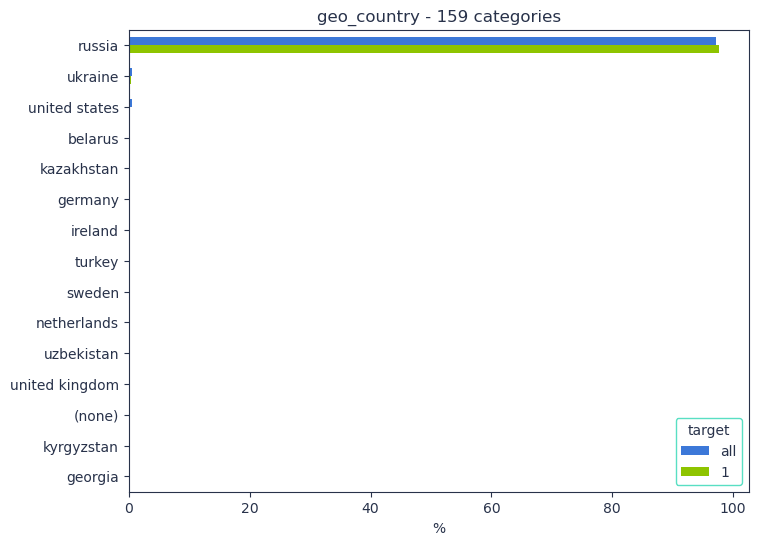

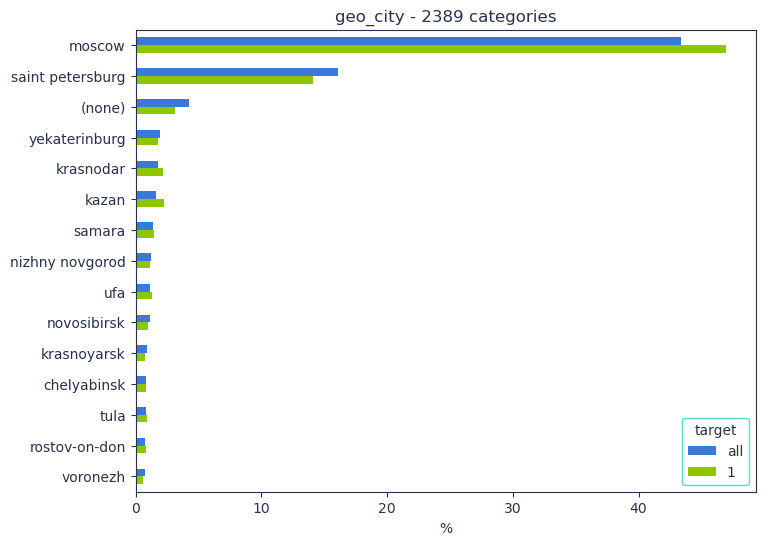

In [36]:
cols_geo = ['geo_country', 'geo_city']
plot_categorical_stats(cols_geo)

Признак geo_country, где почти все значения Россия, бесполезен. Поэтому удалим его.

In [37]:
df.drop(columns=['geo_country'], inplace=True)

Еще раз посмотрим на процент записей с целевым действием:

In [38]:
print(len(df))
print(len(df[df['target'] == 1]))
print(100 * len(df[df['target'] == 1]) / len(df))

1732218
50314
2.9045997674657578
